First of all we need all the necessary librarys to run this beauty!

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from random import randrange, shuffle
from os import path
import librosa
from librosa.display import specshow
import IPython.display as ipd
from math import floor
import time

***Check to see if GPU is available

In [2]:
if (len(tf.config.experimental.list_physical_devices("GPU")) > 0):
    print("GPU is available!")
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.75)
    sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

GPU is available!


Open and read the csv with all the audio information

In [3]:
csvPath    = r"F:\labeled_audio_data.csv"
specPath   = r"C:\Users\cboen\Documents\Programmierungen\AudioDataScience\Labeled_Specs"
audioPath  = r"F:\Labeled_Audio"
modelPath  = r"F:\Models"
logPath    = r"F:\Logs"

version      = r"1.2" #When you make changes, update the version!!
creationTime = time.strftime("%d.%m.%H.%M.%S", time.localtime())

dataFrame = pd.read_csv(csvPath)
dataDictionary = dataFrame.to_dict()
print(dataDictionary.keys())

dict_keys(['Unnamed: 0', 'filename', 'mainSound', 'length', 'sampleRate', 'quality', 'isCut', 'isMixed', 'isChecked', 'threat', 'salience', 'importance'])


Now just use a snippet of the data for now,
This is to be RAM friendly and for testing purposes.
The Training and Test Data will be a list containing a list that looks like the following:
(filename, mainsound, spectrogram, threat, salience, importance)
filename is a string of the filename
mainsound is a string of the sound category
Spectrogram holds a numpy array of the log spectrogram
threat, salience and importance are single numbers and the output values

In [4]:
numAudiosPerBatch = 2500 #Number of audiofiles to train with per Batch

allFileNames = list(dataDictionary['filename'].values())
#allMainSound = list(dataDictionary['mainSound'].values())
#allThreat = list(dataDictionary['threat'].values())
#allSalience = list(dataDictionary['salience'].values())
#allImportance = list(dataDictionary['importance'].values())

training_data = []

dataIndex = 0
numBatches   = floor(len(allFileNames) / numAudiosPerBatch)
testDataSize = len(allFileNames) % numAudiosPerBatch
print("TrainBatches:", numBatches, ", Testdata:", testDataSize)

ids = list(range(0, len(allFileNames)))
shuffle(ids) #, int(time.strftime("%S", time.localtime()))/60

def createTrainingData():
    #ID list ro iterate through all the data
    global dataIndex
    print("Get new training data: ", int(dataIndex/numAudiosPerBatch), "/", (numBatches-1), sep = "")
    for i in range(numAudiosPerBatch):
        perc = int( 20 * i / numAudiosPerBatch)
        bar = "[" + "=" * (perc) + ">" + "-" * (19-perc) + "]"
        print(bar, end="\r")
        audioFile = ids[i+dataIndex]
        filename = allFileNames[audioFile]
        #Load the spectrogram
        try:
            specFilePath = path.join(specPath, (filename+".npz"))
            spectrogramNP = np.load(specFilePath)
            spectrogram = spectrogramNP[spectrogramNP.files[0]]
            spectrogram = spectrogram[0]
            #Load the target values
            mainSound  = dataDictionary['mainSound'][audioFile]
            threat     = dataDictionary['threat'][audioFile]      / 10 #Bring the data from 0-9 to 0.0 - 0.9
            salience   = dataDictionary['salience'][audioFile]    / 10
            importance = dataDictionary['importance'][audioFile]  / 10
        
            training_data.append([filename, mainSound, spectrogram, threat, salience, importance])
        except:
            pass
    dataIndex += numAudiosPerBatch
    print()
    print("Done!")

test_data = []

def createTestData():
    for i in range(len(allFileNames)-testDataSize, len(allFileNames)):
        audioFile = ids[i]
        filename = allFileNames[audioFile]
        #Load the spectrogram
        try:
            specFilePath = path.join(specPath, (filename+".npz"))
            spectrogramNP = np.load(specFilePath)
            spectrogram = spectrogramNP[spectrogramNP.files[0]]
            spectrogram = spectrogram[0]
            #Load the target values
            mainSound  = dataDictionary['mainSound'][audioFile]
            threat     = dataDictionary['threat'][audioFile]      / 10 #Map the target values from 0-9 to 0.0 - 0.9
            salience   = dataDictionary['salience'][audioFile]    / 10
            importance = dataDictionary['importance'][audioFile]  / 10
        
            test_data.append([filename, mainSound, spectrogram, threat, salience, importance])
        except:
            pass

createTrainingData()
createTestData()
spec_width  = len(training_data[0][2])
spec_height = len(training_data[0][2][0])
#print(spec_width, spec_height, sep="|") #spectrogram size:

#del allMainSound, allThreat, allSalience, allImportance, ids

TrainBatches: 1 , Testdata: 232
Get new training data: 0/0
[===================>]
Done!


***Lets plot a random spectrogram!

71177-8-1-4  :  siren


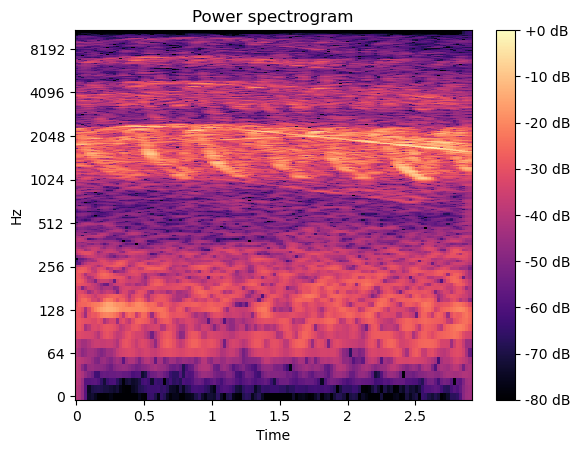

In [5]:
audioToPick = randrange(0,len(training_data),1)
print(training_data[audioToPick][0], " : ",  training_data[audioToPick][1])
#plt.imshow(training_data[audioToPick][2], cmap="plasma", aspect="auto")
fig, ax = plt.subplots()
img = specshow(training_data[audioToPick][2], y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
ipd.Audio(path.join(audioPath, (training_data[audioToPick][0]+".wav")))

***Lets describe the dataset:

In [6]:
def describeTrainingData():
    print("Number of audiofiles:", len(training_data))
    print("Lets get the percentage of each Class:")
    categorys = set(dataDictionary['mainSound'].values())
    trainingDataCategorys = [data[1] for data in training_data] 
    for key in categorys:
        print("Key:", key.ljust(17, " "), ", perc.:", round(trainingDataCategorys.count(key)/len(training_data), 3))
    del categorys, trainingDataCategorys

describeTrainingData()

Number of audiofiles: 2427
Lets get the percentage of each Class:
Key: gunshot           , perc.: 0.065
Key: animal            , perc.: 0.03
Key: car_horn          , perc.: 0.066
Key: clock_alarm       , perc.: 0.007
Key: natural           , perc.: 0.07
Key: fire              , perc.: 0.002
Key: crying_baby       , perc.: 0.01
Key: interior          , perc.: 0.049
Key: exterior          , perc.: 0.287
Key: fireworks         , perc.: 0.007
Key: screaming         , perc.: 0.0
Key: explosion         , perc.: 0.01
Key: siren             , perc.: 0.278
Key: human             , perc.: 0.121


In [29]:
train_x=[]
train_y=[]
def sortTrainingData():
    global train_x, train_y
    train_x = [data[2] for data in training_data]
    #train_y = [[data[3], data[4], data[5]] for data in training_data]
    train_y = [[0.5, 0, 1] for data in training_data]
    train_x = np.array(train_x).reshape(-1, spec_width, spec_height, 1)
    train_y = np.array(train_y)

sortTrainingData()

Now the really fun part!
Create a Convolutional network that can get one spectrogram as input data and outputs three levels for threat, salience and importance!

In [8]:
model = keras.models.Sequential([
    #Input layer
    keras.layers.Conv2D(64, (3,3), strides=(1,1), padding="valid", activation="relu", input_shape=train_x.shape[1:]),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(32, (3,3), strides=(1,1), activation="relu"),
    keras.layers.MaxPool2D((2,2)),
    #...repeat until happy...
    
    #Flatten layer: make 1D out of 2D
    keras.layers.Flatten(),
    
    #Hidden layer(s) 
    #keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dense(32, activation = 'gelu'),
    keras.layers.Dense(16, activation = 'sigmoid'),
    
    #output layer
    keras.layers.Dense(3, activation = 'sigmoid'),
])

modelName = "2Conv2Dense-{}-".format(creationTime) + version
print("Name:", modelName)
print(model.summary())

optimizer = keras.optimizers.Adam(learning_rate = 0.01)
tensorboard = tf.keras.callbacks.TensorBoard(path.join(logPath, modelName), histogram_freq=1)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

Name: 2Conv2Dense-13.03.15.00.53-1.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1023, 124, 64)     640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 511, 62, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 509, 60, 32)       18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 254, 30, 32)       0         
_________________________________________________________________
flatten (Flatten)            (None, 243840)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                7802912   
_________________________________________________________________
dense_1 (Dense)    

Now lets get the first training session done!

In [30]:
for batch in range((numBatches-1)):
    try:
        model.fit(train_x, train_y, validation_split=0.1,batch_size=20, epochs=5, callbacks=[tensorboard])
    except Exception as e:
        print("Something went wrong!")
        print(e)
    training_data = []
    createTrainingData()
    sortTrainingData()

try:
    model.fit(train_x, train_y, validation_split=0.1,batch_size=20, epochs=5, callbacks=[tensorboard])
except Exception as e:
    print("Something went wrong!")
    print(e)

Epoch 1/5
110/110 [==============================] - 6s 57ms/step - loss: 9.4450 - accuracy: 1.0000 - val_loss: 9.1005 - val_accuracy: 1.0000
Epoch 2/5
110/110 [==============================] - 6s 52ms/step - loss: 8.7416 - accuracy: 1.0000 - val_loss: 8.3654 - val_accuracy: 1.0000
Epoch 3/5
110/110 [==============================] - 6s 53ms/step - loss: 7.9914 - accuracy: 1.0000 - val_loss: 7.6001 - val_accuracy: 1.0000
Epoch 4/5
110/110 [==============================] - 6s 52ms/step - loss: 7.2122 - accuracy: 1.0000 - val_loss: 6.8068 - val_accuracy: 1.0000
Epoch 5/5
110/110 [==============================] - 6s 52ms/step - loss: 6.4060 - accuracy: 1.0000 - val_loss: 5.9875 - val_accuracy: 1.0000


***Lets let the model predict some data!

In [41]:
i = randrange(dataIndex, len(allFileNames), 1)
audioFile = ids[i]
filename = allFileNames[audioFile]
specFilePath = path.join(specPath, (filename+".npz"))
spectrogramNP = np.load(specFilePath)
spectrogram = spectrogramNP[spectrogramNP.files[0]]
spectrogram = spectrogram[0]
test_x = np.array(spectrogram).reshape(-1, spec_width, spec_height, 1)
test_y = np.array([dataDictionary['threat'][ids[i]], dataDictionary['salience'][ids[i]], dataDictionary['importance'][ids[i]]])
print("Infos: ", end="")
print( filename, dataDictionary['mainSound'][ids[i]], sep=" | ")
#print(path.join(audioPath, (filename+".wav")))
print("Goal:  ", test_y / 10)
prediction = model(test_x)
print("Result: ", end="")
print(prediction.numpy()[0])
ipd.Audio(path.join(audioPath, (filename+".wav")))

Infos: 3-100024-B-27 | human
Goal:   [0.02418967 0.37191552 0.0740661 ]
Result: [2.511583e-16 9.996850e-04 9.988030e-01]


In [11]:
training_data = test_data[:]
sortTrainingData()
predict_y = model.predict(train_x)

***Get total errors of the test dataset

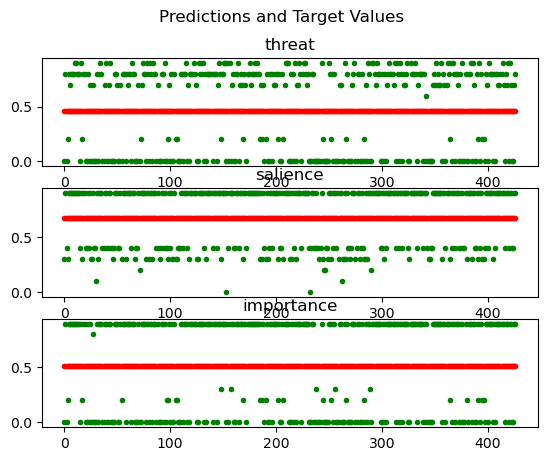

In [12]:
targetLabels = ["threat", "salience", "importance"]
fig, axs = plt.subplots(3)
fig.suptitle("Predictions and Target Values")
for targetVal in range(3):
    values_y = np.array([train_y[:, targetVal], predict_y[:, targetVal]])
    #values_y_sorted = values_y[np.lexsort((values_y[:, 0], values_y[:, 1]))]
    value_diff = [values_y[1][i]-values_y[0][i] for i in range(len(values_y[0]))]
    axs[targetVal].plot(values_y[0], ".g",)
    axs[targetVal].plot(values_y[1], ".r",)
    #value_diff.sort()
    #axs[targetVal].plot(value_diff, "-m",)
    axs[targetVal].set_title(targetLabels[targetVal])

Last but not least, lets save the model.

In [13]:
model.evaluate(train_x, train_y)

14/14 [==============================] - 0s 28ms/step - loss: 0.6677 - accuracy: 0.8525


[0.6677067279815674, 0.8524590134620667]

In [14]:
model.save(path.join(modelPath, modelName))

INFO:tensorflow:Assets written to: F:\Models\1Conv2Dense-13.03.14.04.28-1.2\assets
